In [1]:
# Os File operations and data processing
import os  
# Random number generation
import random
# XML parsing
import xmltodict 

# Image operations and visualization
from PIL import Image  
import matplotlib.pyplot as plt 

# Data processing and GPU device support
import torch 
# Base class for Neural Network modules
import torch.nn as nn
# Abstract class for the dataset representation
from torch.utils.data import Dataset  
# Makes dataset iterable through sampler 
from torch.utils.data import DataLoader 
# Various optimization algorithms 
import torch.optim as optim  
# Sheduler for adjusting learning rate during training
from torch.optim.lr_scheduler import StepLR 

# Model summary for PyTorch models
from torchsummary import summary 

# Image transformations during the data loading process
from torchvision import transforms 
# Pre-trained models libary (vgg16)
import torchvision.models as torchmodels  

# Visualization of training and evaluation process
from tqdm.notebook import tqdm  

In [2]:
# Check if GPU availability and set the device
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda")
else:
    print("No GPU available, using CPU")
    device = torch.device("cpu")

# Check if the device is set correctly
print(f"Device set to: {device}")

Using GPU: NVIDIA GeForce RTX 3060
Device set to: cuda


Dataset directory structure:
/opt/nfs/shared/images/ImageNetDogs
├── Annotation
├── file_list.mat
├── Images
├── README.txt
├── test_data.mat
├── test_list.mat
├── train_data.mat
└── train_list.mat

2 directories, 6 files

Images folder structure:
/opt/nfs/shared/images/ImageNetDogs/Images/n02085620-Chihuahua:                      directory
/opt/nfs/shared/images/ImageNetDogs/Images/n02085782-Japanese_spaniel:               directory
/opt/nfs/shared/images/ImageNetDogs/Images/n02085936-Maltese_dog:                    directory
/opt/nfs/shared/images/ImageNetDogs/Images/n02086079-Pekinese:                       directory
/opt/nfs/shared/images/ImageNetDogs/Images/n02086240-Shih-Tzu:                       directory

Number of Categories:
120

Total number of images:
20580

Observing 4 random images from the dataset:

Image 1 resolution:
/opt/nfs/shared/images/ImageNetDogs/Images/n02096177-cairn/n02096177_12360.jpg : (500, 375) pixels

Image 2 resolution:
/opt/nfs/shared/images/ImageNetDo

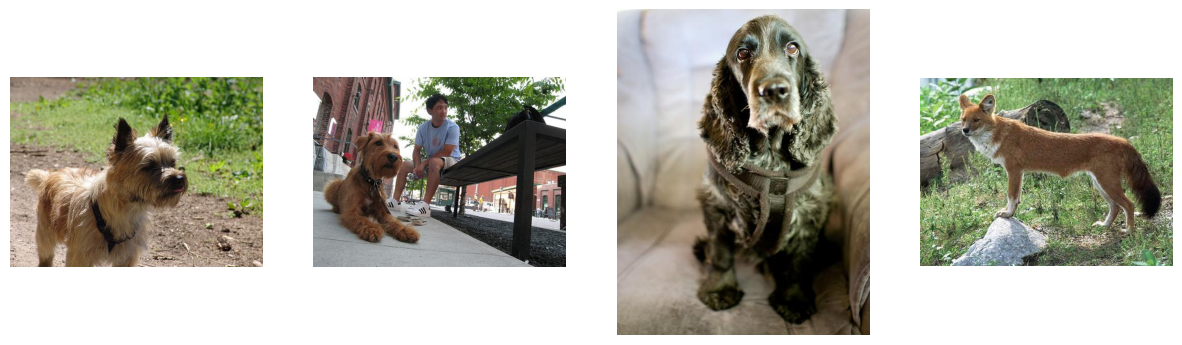

In [3]:
# Define dataset directory
dataset_dir = '/opt/nfs/shared/images/ImageNetDogs'

# List dataset contents
print("Dataset directory structure:")
os.system(f'tree {dataset_dir} -L 1')

"""
Read the README file
print("\nREADME file:")
os.system(f'cat {dataset_dir}/README.txt')
"""

# Check the structure of the Images Folder
print("\nImages folder structure:")
os.system(f'file {dataset_dir}/Images/* | head -n 5')

# Number of Categories
print("\nNumber of Categories:")
os.system(f'ls {dataset_dir}/Images | wc -l')

# Number of total images in Images folder
print("\nTotal number of images:")
os.system(f'find {dataset_dir}/Images -type f | wc -l')

# Declare the number of random images to display
ran_img = 4

# Create subplots
fig, axs = plt.subplots(1, ran_img, figsize=(15, 5))

# Load, display and analyze 4 random images
print("\nObserving " + str(ran_img) +" random images from the dataset:")
for i in range(ran_img):
    img_path = os.popen(f'find {dataset_dir}/Images -type f | shuf -n 1').read().strip()
    img = Image.open(img_path)
    
    # Display image in subplot
    axs[i].imshow(img)
    axs[i].axis('off')
    
    # Check the image resolution
    print("\nImage " + str(i+1) + " resolution:")
    print(f"{img_path} : {img.size} pixels")

# Show all subplots
plt.show()

In [4]:
def split_dataset(data_dir, train_ratio=0.7, val_ratio=0.15, num_classes=None, seed=None):

    # Set seed for reproducibility if provided
    if seed is not None:
        random.seed(seed)
    # Otherwise, set a random seed
    else:
        random.seed()

    # Get the sorted list of classifications
    classes = sorted(os.listdir(data_dir))

    # Check if a specified number of classes is provided
    if num_classes is not None:
        # Make an upper bound to the number of classes
        classes = classes[:num_classes]

    # Create a dictionary mapping the class breed names to integers
    breed_dict = {breed: i for i, breed in enumerate(classes)}

    # Initialize the 3 splits sets
    train_set = []
    val_set = []
    test_set = []

    # Iterate over the classes
    for breed in classes:
        # Get the list of images for the current class
        img_list = os.listdir(os.path.join(data_dir, breed))
        # Make sure only images are captured (should do nothing)
        img_list = [img for img in img_list if img.endswith('.jpg')]
        
        # Shuffle the list of images
        random.shuffle(img_list)

        # Calculate the split indexes
        num_train = int(len(img_list) * train_ratio)
        num_val = int(len(img_list) * val_ratio)
        
        # Split the images into the 3 sets
        train_set += [(os.path.join(data_dir, breed, img), breed_dict[breed]) for img in img_list[:num_train]]
        val_set += [(os.path.join(data_dir, breed, img), breed_dict[breed]) for img in img_list[num_train:num_train + num_val]]
        test_set += [(os.path.join(data_dir, breed, img), breed_dict[breed]) for img in img_list[num_train + num_val:]]

    # Return the 3 sets and the breed dictionary
    return train_set, val_set, test_set, breed_dict

In [5]:
class DataLoaderClassification(Dataset):
    # Initialization function
    def __init__(self, image_set, breed_dict, transform=None):
        # Initialize the dataset by passing the touple of image path and label, breed dictionary and transformation to be applied
        self.image_set = image_set
        self.breed_dict = breed_dict
        self.transform = transform

    # Length function
    def __len__(self):
        # Simply return the length of the image set
        return len(self.image_set)
    
    # Load idx-th item
    def __getitem__(self, idx):
        # Since the image_set contains tuples of (image_path, label), we can directly access the image path by taking the first element of the tuple
        img_path = self.image_set[idx][0]
        
        # Make sure the image file exists
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image file not found: {img_path}")
    
        # Open the image
        img = Image.open(img_path)
        
        # Get the respective bounding box file path
        bbox_path = img_path.replace('Images', 'Annotation').removesuffix('.jpg') 
        
        # Check if the bounding box file exists
        if not os.path.exists(bbox_path):
            raise FileNotFoundError(f"Bounding box file not found: {bbox_path}")
        
        # Parse the bounding box XML file
        with open(bbox_path) as fd:
            doc = xmltodict.parse(fd.read())
        
        # Handle multiple objects in the annotation
        objects = doc['annotation']['object']
        if isinstance(objects, list):
            bndbox = objects[0]['bndbox']  # Use the first object's bounding box
        else:
            bndbox = objects['bndbox']

        # Set the bounding box coordinates
        xmin = int(bndbox['xmin'])
        ymin = int(bndbox['ymin'])
        xmax = int(bndbox['xmax'])
        ymax = int(bndbox['ymax'])
            
        # Crop the image using the bounding box coordinates
        img = img.crop((xmin, ymin, xmax, ymax))
        
        # Apply transformation if any
        if self.transform:
            img = self.transform(img)
        
        # To get the label, we can simply take the second element of the tuple
        label = self.image_set[idx][1]
        
        # Return the image and the label
        return img, label

In [6]:
# Define the transformation to be applied on the training set.
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Lambda(lambda img: img.convert('RGB')),  
    transforms.ToTensor(),
])

# Define the transformation to be applied on the validation set
val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Lambda(lambda img: img.convert('RGB')), 
    transforms.ToTensor(),
])

# Define the dataset image directory
directory = '/opt/nfs/shared/images/ImageNetDogs/Images'

# Split the dataset using the split_dataset function
train_set, val_set, test_set, breed_dict = split_dataset(directory, train_ratio=0.7, val_ratio=0.15)

# Set the number of classes
num_classes = len(breed_dict)

# Reverse dictionary to map labels to breed names
label_dict = {label: breed for breed, label in breed_dict.items()}

# Initialize the DataLoaderClassification objects for the train, val and test sets
train_loader = DataLoaderClassification(train_set, breed_dict, transform=train_transform)
val_loader = DataLoaderClassification(val_set, breed_dict, transform=val_transform)
test_loader = DataLoaderClassification(test_set, breed_dict, transform=val_transform)

# Define the batch size for the data loaders (how many samples to load at once when loading the data from dataloader)
batch_size = 64

# Use the DataLoader class to create the data loaders for the train, val and test sets based on the DataLoaderClassification objects
train_loader = DataLoader(train_loader, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_loader, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_loader, batch_size=batch_size, shuffle=False)


# Get the total number of samples in the dataset (if all breeds are considered)
total_samples = int(os.popen(f'find {directory} -type f | wc -l').read().strip())
# The number of samples in the training, validation and test sets
train_samples = len(train_loader.dataset)
val_samples = len(val_loader.dataset)
test_samples = len(test_loader.dataset)
print(f"Total samples in the dataset: {total_samples}")
print(f"Samples in the training set: {train_samples}")
print(f"Samples in the validation set: {val_samples}")
print(f"Samples in the test set: {test_samples}")
# Check if the totals match
if total_samples == (train_samples + val_samples + test_samples):
    print("Data split successful")
else:
    print("Data split unsuccessful")
    print(f"Total samples is meant to be {total_samples} but got {train_samples + val_samples + test_samples}")

Total samples in the dataset: 20580
Samples in the training set: 14355
Samples in the validation set: 3025
Samples in the test set: 3200
Data split successful


In [7]:
# A simple CNN model subclassing the nn.Module class
class CNN(nn.Module):
    # Initialization function definines the layers
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)

        # Activation function
        self.relu = nn.ReLU()
        # Pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1) 

        # Fully connected layer
        self.fc1 = nn.Linear(32, num_classes)

    # Forward function defines the forward pass
    def forward(self, x):
        # First convolutional layer
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        # Second convolutional layer
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        # Global average pooling
        x = self.global_avg_pool(x) 
        # Flatten the tensor 
        x = x.view(x.size(0), -1) 
        # Fully connected layer
        x = self.fc1(x)  
        return x

# Initialize the CNN
simple_model = CNN()

# Move the model to the device
simple_model = simple_model.to(device)

# Set the model path
simple_model_path = './Model/Simple-CNN/simple-model.pth'

# Print the number of parameters in the model
summary(simple_model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             448
              ReLU-2         [-1, 16, 128, 128]               0
         MaxPool2d-3           [-1, 16, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]           4,640
              ReLU-5           [-1, 32, 64, 64]               0
         MaxPool2d-6           [-1, 32, 32, 32]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Linear-8                  [-1, 120]           3,960
Total params: 9,048
Trainable params: 9,048
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 6.75
Params size (MB): 0.03
Estimated Total Size (MB): 6.97
----------------------------------------------------------------


In [8]:
def indv_epoch_train(model, train_loader, criterion, optimizer, device):
    # Set the model to training mode
    model.train()
    
    # Initialize the running loss and correct predictions
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Iterate over the training data
    for images, labels in train_loader:
        # Move the images and labels to the device
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(images)
        # Calculate the loss
        loss = criterion(outputs, labels)
        # Backward pass
        loss.backward()

        # Update the weights
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        optimizer.step()

        # Add the loss to the running loss
        running_loss += loss.item()
        # Get the predicted labels
        _, predicted = torch.max(outputs.data, 1)
        # Update the total and correct predictions
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    # Calculate the epoch loss and accuracy
    epoch_loss = running_loss / len(train_loader)
    # Calculate the accuracy
    train_accuracy = correct_train / total_train
    # Return the epoch loss and accuracy
    return epoch_loss, train_accuracy 

In [9]:
def evaluate_model(model, val_loader, criterion, device):
    # Set the model to evaluation mode
    model.eval()

    # Initialize the running loss and correct predictions
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    # Iterate over the validation data without gradient tracking
    with torch.no_grad():
        # Iterate over the validation data
        for images, labels in val_loader:
            # Move the images and labels to the device
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            # Calculate the loss
            loss = criterion(outputs, labels)
            # Add the loss to the running loss
            running_val_loss += loss.item()
            # Get the predicted labels
            _, predicted = torch.max(outputs.data, 1)
            # Update the total and correct predictions
            correct_val += (predicted == labels).sum().item()
            # Update the total number of samples
            total_val += labels.size(0)
    # Calculate the validation loss and accuracy
    val_loss = running_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    # Return the validation loss and accuracy
    return val_loss, val_accuracy

In [10]:
def metric_plot(train_accuracies, val_accuracies, train_losses, val_losses, num_epochs):
    # Create a figure and a set of subplots
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Number of Epochs')
    plt.grid(True)
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='blue')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs. Number of Epochs')
    plt.grid(True)
    plt.legend()

    plt.show()

In [11]:
def save_model(model, model_path, val_acc, best_acc, epoch, optimizer=None, save_interval=10):
    # Determine if the model should be saved
    save_condition = (val_acc > best_acc) or (epoch % save_interval == 0)

    # Append 'best_' to the model path if the current validation accuracy is better than the previous best accuracy
    if val_acc > best_acc:
        model_pth = model_path.replace('.pth', '-best.pth')
    else:
        model_pth = model_path

    # Check the save condition
    if save_condition:
        # Save the model checkpoint
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict() if optimizer else None,
            'val_acc': val_acc,
            'best_acc': best_acc,
        }

        # Ensure the directory exists before saving
        os.makedirs(os.path.dirname(model_pth), exist_ok=True)
        
        # Save the model checkpoint
        torch.save(checkpoint, model_pth)
        # For best model we will have a different path than the recurrenct saving
        print(f"Model saved at {model_pth}")

        # Update the best accuracy if the current validation accuracy is better
        if val_acc > best_acc:
            best_acc = val_acc

    return best_acc

In [12]:
def train_eval(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs,
    model_path,
    metric_plot_fn,
    indv_epoch_train_fn,
    evaluate_model_fn,
    save_model_fn,
    sheduler = None
):
   
    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []
    best_accuracy = 0.0

    progress_bar = tqdm(range(num_epochs), desc="Training Progress", dynamic_ncols=True)

    for epoch in progress_bar:
        # Training
        train_loss, train_accuracy = indv_epoch_train_fn(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Evaluation
        val_loss, val_accuracy = evaluate_model_fn(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        if sheduler is not None:
            sheduler.step()

        # Save the best model
        best_accuracy = save_model_fn(model, model_path, val_accuracy, best_accuracy, epoch, optimizer)

        # Update the progress bar
        progress_bar.set_postfix_str(
            f"Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%"
        )

    # Plot metrics
    metric_plot_fn(train_accuracies, val_accuracies, train_losses, val_losses, num_epochs)

    # Print highest validation accuracy
    print(f"Highest Validation Accuracy: {100 * best_accuracy:.2f}%")

    return

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
         MaxPool2d-7           [-1, 64, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]          73,856
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
        MaxPool2d-14          [-1, 128,

Training Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Model saved at ./Model/VGG16/vgg16-1-model-best.pth
Model saved at ./Model/VGG16/vgg16-1-model-best.pth
Model saved at ./Model/VGG16/vgg16-1-model-best.pth
Model saved at ./Model/VGG16/vgg16-1-model-best.pth
Model saved at ./Model/VGG16/vgg16-1-model-best.pth


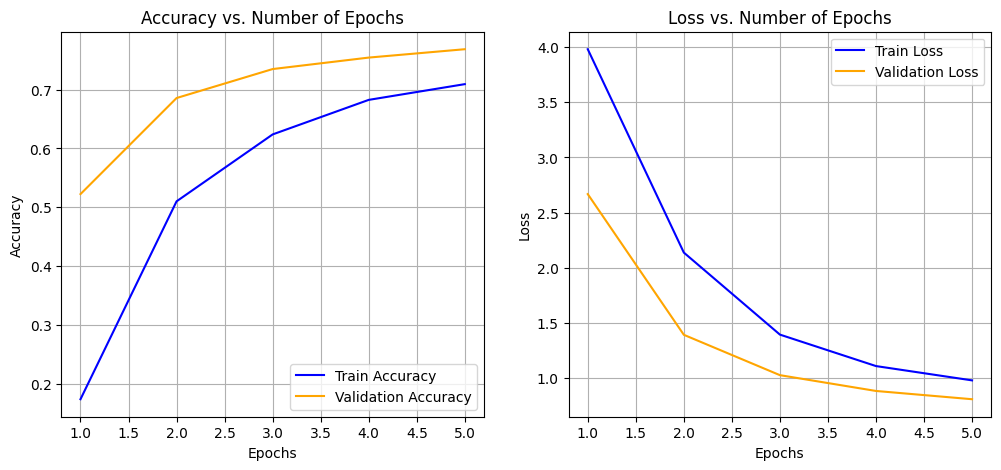

Highest Validation Accuracy: 76.86%


Training Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Model saved at ./Model/VGG16/vgg16-1-model-best.pth
Model saved at ./Model/VGG16/vgg16-1-model-best.pth
Model saved at ./Model/VGG16/vgg16-1-model-best.pth
Model saved at ./Model/VGG16/vgg16-1-model-best.pth
Model saved at ./Model/VGG16/vgg16-1-model-best.pth
Model saved at ./Model/VGG16/vgg16-1-model-best.pth
Model saved at ./Model/VGG16/vgg16-1-model-best.pth
Model saved at ./Model/VGG16/vgg16-1-model-best.pth
Model saved at ./Model/VGG16/vgg16-1-model-best.pth
Model saved at ./Model/VGG16/vgg16-1-model-best.pth


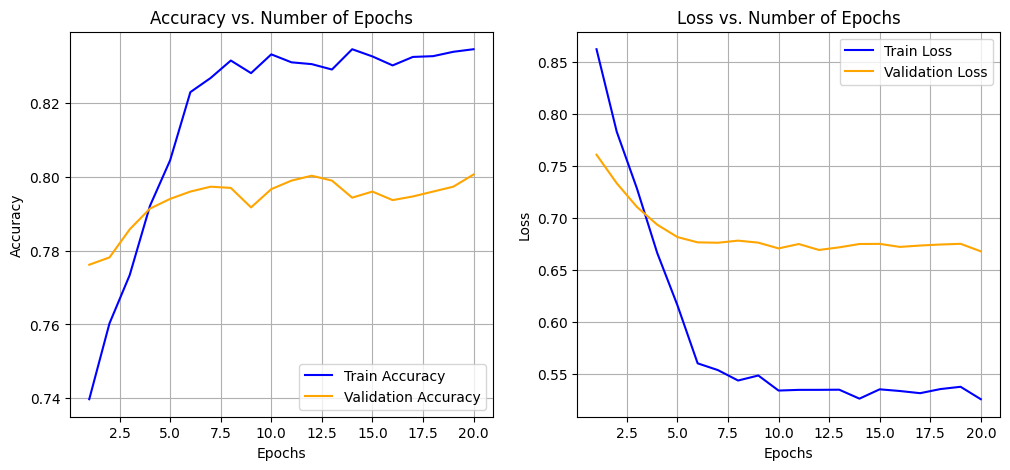

Highest Validation Accuracy: 80.07%


In [13]:
import torch.nn.utils.prune as prune

# Define the base model path
vgg16_base_path = './Model/VGG16/vgg16-base.pth'

# Initialize the VGG16_1 model
vgg16_1_model = torchmodels.vgg16_bn(weights=None)
# Load the base model weights
vgg16_1_model.load_state_dict(torch.load(vgg16_base_path))

# Freeze the initial layers
for param in vgg16_1_model.features[:24].parameters():
    param.requires_grad = False

# Change the output layer to match the number of classes
vgg16_1_model.classifier[6] = nn.Linear(4096, num_classes)

# Move the model to the device
vgg16_1_model = vgg16_1_model.to(device)

# Set the model path
vgg16_1_model_path = './Model/VGG16/vgg16-1-model.pth'

# Print the model summary to check parameters
summary(vgg16_1_model, (3, 128, 128))

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Use the same optimizer as previously
optimizer = optim.SGD(filter(lambda p: p.requires_grad, vgg16_1_model.parameters()), lr=0.001, momentum=0.9)

# Add a scheduler to adjust the learning rate
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# Define the number of epochs
num_epochs = 25

# Train the model for a few epochs before pruning
initial_epochs = 5
train_eval(
    vgg16_1_model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    initial_epochs,
    vgg16_1_model_path,
    metric_plot,
    indv_epoch_train,
    evaluate_model,
    save_model
)

# Apply pruning gradually
for module in vgg16_1_model.features:
    if isinstance(module, nn.Conv2d):
        prune.l1_unstructured(module, name='weight', amount=0.1)  # Prune 10% of the weights

# Continue training after pruning
remaining_epochs = num_epochs - initial_epochs
train_eval(
    vgg16_1_model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    remaining_epochs,
    vgg16_1_model_path,
    metric_plot,
    indv_epoch_train,
    evaluate_model,
    save_model,
    scheduler
)